<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks-d2l/naive_bayes_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes classifiers
This Colab shows you an implementation of a Naive Bayes classifiers from scratch using Numpy.
This classifier obtains 84.27% accuracy on the MNIST test set.

We use binary features, and 2 classes (based on sec 18.9 of http://d2l.ai/chapter_appendix-mathematics-for-deep-learning/naive-bayes.html).




In [24]:
# Assignment 3 - Naive Bayes classification on MNIST
# Machine Learning class: COMP 5630/6630/6630-D01
# Spring 2023
# Anh Nguyen <anh.ng8@gmail.com>

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(seed=1)
import math
import collections
import os
import random

import json
import multiprocessing

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
from torch import nn
from torch.nn import functional as F

try:
    import torchvision
except ModuleNotFoundError:
    %pip install -qq torchvision
    import torchvision

!mkdir figures # for saving plots

# !wget https://raw.githubusercontent.com/d2l-ai/d2l-en/r0.17/d2l/torch.py -q -O d2l.py
# import d2l

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = d2l.numpy(img)
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes 

mkdir: cannot create directory ‘figures’: File exists


# Get data

We use a binarized version of MNIST.

In [25]:
data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST(root="./temp", train=True, transform=data_transform, download=True)
mnist_test = torchvision.datasets.MNIST(root="./temp", train=False, transform=data_transform, download=True)

In [26]:
print(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./temp
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [27]:
image, label = mnist_train[2]
print(type(image))
print(image.shape)
print(type(label))
print(label)

<class 'torch.Tensor'>
torch.Size([1, 28, 28])
<class 'int'>
4


In [28]:
image[0, 15:20, 15:20]  # not binary (pytorch rescales to 0:1)

tensor([[0.3569, 0.1098, 0.0196, 0.9137, 0.9804],
        [0.0000, 0.0000, 0.4000, 0.9961, 0.8627],
        [0.0000, 0.0000, 0.6627, 0.9961, 0.5373],
        [0.0000, 0.0000, 0.6627, 0.9961, 0.2235],
        [0.0000, 0.0000, 0.6627, 0.9961, 0.2235]])

In [29]:
[torch.min(image), torch.max(image)]

[tensor(0.), tensor(1.)]

In [30]:
print(mnist_train[0][0].shape)  # (1,28,28)
indices = [0, 1]
xx = torch.stack([mnist_train[i][0] for i in indices])
print(xx.shape)
xx = torch.stack([mnist_train[i][0] for i in indices], dim=1)
print(xx.shape)
xx = torch.stack([mnist_train[i][0] for i in indices], dim=1).squeeze(0)
print(xx.shape)

torch.Size([1, 28, 28])
torch.Size([2, 1, 28, 28])
torch.Size([1, 2, 28, 28])
torch.Size([2, 28, 28])


In [31]:
# convert from torch.tensor to numpy, extract subset of indices, optionally binarize
def get_data(data, indices=None, binarize=True):
    N = len(data)
    if indices is None:
        indices = range(0, N)
    # X = torch.stack([data[i][0] for i in indices], dim=1).squeeze(0) # (N,28,28)
    X = np.stack([data[i][0].numpy() for i in indices], axis=1).squeeze(0)  # (N,28,28)
    if binarize:
        X = X > 0.5
    # y = torch.tensor([data[i][1] for i in indices])
    y = np.array([data[i][1] for i in indices])
    return X, y

[(10, 28, 28), (10,)]
[[0.7294118  0.99215686 0.99215686 0.5882353  0.10588235]
 [0.0627451  0.3647059  0.9882353  0.99215686 0.73333335]
 [0.         0.         0.9764706  0.99215686 0.9764706 ]
 [0.50980395 0.7176471  0.99215686 0.99215686 0.8117647 ]
 [0.99215686 0.99215686 0.99215686 0.98039216 0.7137255 ]]


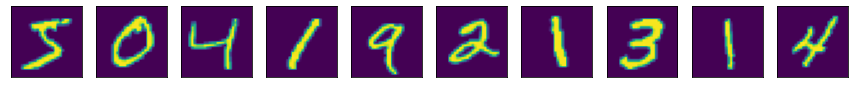

In [32]:
indices = range(0, 10)
images, labels = get_data(mnist_train, indices, False)
print([images.shape, labels.shape])
print(images[0, 15:20, 15:20])  # not binary

show_images(images, 1, 10);

[(10, 28, 28), (10,)]
[[ True  True  True  True False]
 [False False  True  True  True]
 [False False  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


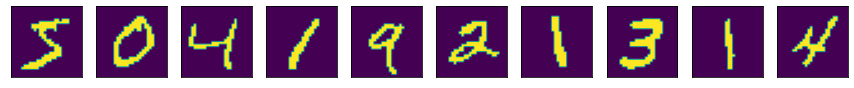

In [33]:
indices = range(0, 10)
images, labels = get_data(mnist_train, indices, True)
print([images.shape, labels.shape])
print(images[0, 15:20, 15:20])  # binary
show_images(images, 1, 10);

In [34]:
X_train, y_train = get_data(mnist_train)
X_test, y_test = get_data(mnist_test)

In [35]:
print(X_train.shape)
print(type(X_train))

print(X_train[0, 15:20, 15:20])

(60000, 28, 28)
<class 'numpy.ndarray'>
[[ True  True  True  True False]
 [False False  True  True  True]
 [False False  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


# Training



Estimating the prior P(Y)

In [36]:
n_y = np.zeros(10)
for y in range(10):
    n_y[y] = (y_train == y).sum()
P_y = n_y / n_y.sum()
print (P_y, "-->", np.sum(P_y))

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] --> 1.0


In [37]:
# Training set is not equally balanced across classes...
print(np.unique(y_train))
from collections import Counter

cnt = Counter(y_train)
print(cnt.keys())
print(cnt.values())

[0 1 2 3 4 5 6 7 8 9]
dict_keys([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])
dict_values([5421, 5923, 5842, 6742, 5949, 5958, 6131, 5918, 6265, 5851])


We use add-one smoothing for class conditional Bernoulli distributions.

In [38]:
n_x = np.zeros((10, 28, 28))
for y in range(10):
    n_x[y] = X_train[y_train == y].sum(axis=0)

P_xy = (n_x + 1) / (n_y + 2).reshape(10, 1, 1)    # MAP estimate of P(X|y) using pseudo counts of 1 (i.e. 1-smoothing)

print(P_xy.shape)
print(type(P_xy))

(10, 28, 28)
<class 'numpy.ndarray'>


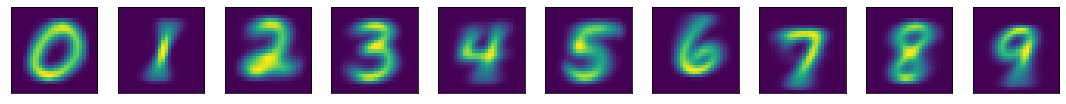

In [39]:
show_images(P_xy, 1, 10)
plt.tight_layout()
plt.savefig("nbc_mnist_centroids.pdf", dpi=300)

# from google.colab import files
# files.download("nbc_mnist_centroids.pdf") 

# Testing

In [40]:
log_P_xy = np.log(P_xy)
log_P_xy_neg = np.log(1 - P_xy)
log_P_y = np.log(P_y)


def bayes_pred_stable(x):
    # x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    x = np.expand_dims(x, 0)  # (28, 28) -> (1, 28, 28)

    # Equivalent to computing the product of the class-conditional probabilities for all the pixels
    # And then taking the log
    p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)  # select the 0 and 1 pixels
    p_xy = p_xy.reshape(10, -1).sum(axis=1)  # p(x|y)

    # Return log of p(y|x) where y = 0, 1, 2, ..., 9 (i.e., 10 MNIST classes)
    return p_xy #+ log_P_y


def predict(X):
    return [np.argmax(bayes_pred_stable(x)) for x in X]


# image, label = mnist_test[0]
image = X_test[0]
label = y_test[0]
py = bayes_pred_stable(image)

print("ytrue ", label, "yhat ", np.argmax(py))
print(predict([image]))

ytrue  7 yhat  0
[0]


<ipython-input-40-780790be6d78>:2: RuntimeWarning: invalid value encountered in log
  log_P_xy_neg = np.log(1 - P_xy)


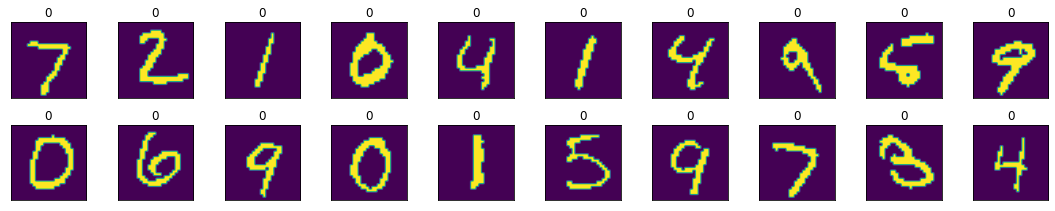

In [41]:
indices = range(0, 20)
X1, y1 = get_data(mnist_test, indices, True)
preds = predict(X1)
show_images(X1, 2, 10, titles=[ str(d) for d in preds])
plt.tight_layout()
plt.savefig("nbc_mnist_preds.pdf", dpi=300)

In [42]:
preds = predict(X_test)
float((preds == y_test).sum()) / len(y_test)  # test accuracy

0.098